In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import joblib
import librosa
import librosa.display
import tarfile
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras import models, layers, utils, callbacks, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import random
import gc

warnings.filterwarnings('ignore')

In [2]:
tar_file = r'C:\Users\Admin\3D Objects\Python\data\genres.tar.gz'

In [3]:
with tarfile.open(tar_file, 'r:gz') as tar:
    tar.extractall()

In [4]:
dataset_dir = 'genres'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [5]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [6]:
# Extract features for each genre and write to CSV
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for genre in genres:
        for filename in os.listdir(f'genres/{genre}'):
            songname = f'genres/{genre}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            rmse = np.mean(librosa.feature.rms(y=y))
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {genre}'
            writer.writerow(to_append.split())

In [7]:
data = pd.read_csv('data.csv')
data = data.drop(['filename'], axis=1)

In [8]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)


In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
Y_train = utils.to_categorical(y_train, num_classes=10)
Y_test = utils.to_categorical(y_test, num_classes=10)

In [12]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [13]:
model = models.Sequential()


In [14]:
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [17]:
batch_size = 32
n_epochs = 50

In [18]:
results = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1478 - loss: 2.4817 - val_accuracy: 0.2500 - val_loss: 2.1516
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2696 - loss: 2.1140 - val_accuracy: 0.2750 - val_loss: 1.9997
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3653 - loss: 1.8845 - val_accuracy: 0.3600 - val_loss: 1.8926
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4010 - loss: 1.8311 - val_accuracy: 0.3850 - val_loss: 1.8272
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4188 - loss: 1.7246 - val_accuracy: 0.3950 - val_loss: 1.7645
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4461 - loss: 1.6431 - val_accuracy: 0.4250 - val_loss: 1.7232
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4147 - loss: 1.6915 - val_accuracy: 0.4350 - val_loss: 1.6757
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4635 - loss: 1.5897 - val_accuracy: 0.4550 - val_loss:

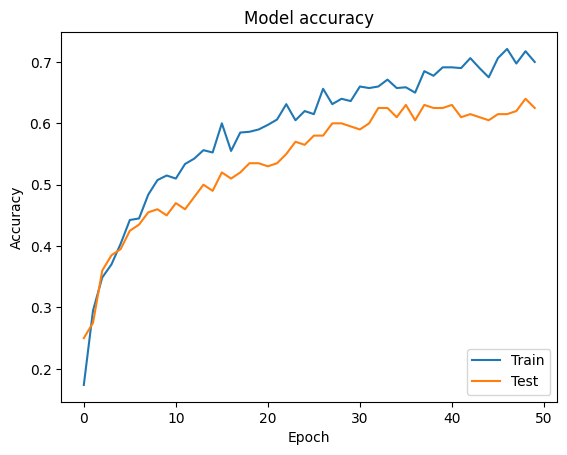

In [19]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

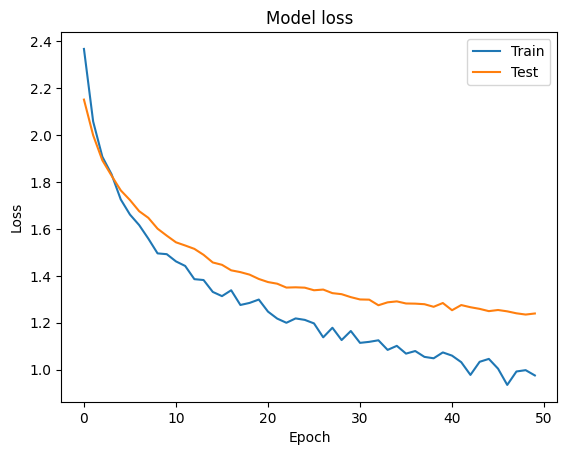

In [20]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [22]:
# Classification Report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.48      0.60      0.53        20
           1       0.93      1.00      0.96        13
           2       0.62      0.56      0.59        27
           3       0.60      0.57      0.59        21
           4       0.62      0.67      0.65        15
           5       0.73      0.73      0.73        22
           6       0.77      0.92      0.84        25
           7       0.59      0.77      0.67        13
           8       0.53      0.35      0.42        23
           9       0.53      0.43      0.47        21

    accuracy                           0.64       200
   macro avg       0.64      0.66      0.64       200
weighted avg       0.63      0.64      0.63       200



In [23]:
# Save the model
model.save('music_genre_classification.h5')

In [24]:
# Load the saved models
model = load_model('music_genre_classification.h5')
scaler = joblib.load('scaler.pkl')  
encoder = joblib.load('label_encoder.pkl')

In [25]:
# Choose a random music file from the dataset directory
test_directory = 'genres'
genre = random.choice(genres)
random_filename = random.choice(os.listdir(f'{test_directory}/{genre}'))
random_filepath = os.path.join(test_directory, genre, random_filename)
print(f"Random file chosen for testing: {random_filepath}")

Random file chosen for testing: genres\metal\metal.00039.au


In [26]:
y, sr = librosa.load(random_filepath, mono=True, duration=30)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
rmse = np.mean(librosa.feature.rms(y=y))
mfcc = librosa.feature.mfcc(y=y, sr=sr)

In [27]:
features = np.array([
    np.mean(chroma_stft), np.mean(rmse), np.mean(spec_cent),
    np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)
] + [np.mean(m) for m in mfcc])

In [28]:
features = features.reshape(1, -1)
scaled_features = scaler.transform(features)

In [29]:
predicted_genre_index = np.argmax(model.predict(scaled_features), axis=1)[0]
predicted_genre = encoder.inverse_transform([predicted_genre_index])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [30]:
print(f"Predicted genre: {predicted_genre}")

Predicted genre: metal


In [31]:
print(f"Random file chosen for testing: {random_filepath}")

Random file chosen for testing: genres\metal\metal.00039.au
